In [15]:
# !pip install xlrd
# !pip install openpyxl
# !pip install geopy
# !pip install streamlit-folium

import requests
import pandas as pd
from pandas import json_normalize
import plotly.express as px
import streamlit as st 
import numpy as np
import folium
from folium import plugins
import streamlit_folium as st_folium
from streamlit_folium import folium_static
import calendar
from datetime import timedelta
import plotly.graph_objects as go
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns


import geopandas as gpd
import folium
from folium import plugins
import geopy

In [17]:
# !pip install session.info
# import session_info
# session_info.show()

KeyError: 'fiona'

In [3]:
st.title('2022-2023 sem-1 Case 3: Dashboard')
st.header('Elektrisch mobiliteit en laadpalen')
st.subheader(' Team 7: Olger, Bart, Annika, Estelle') 
##### Inleidende tekst 
st.text('In dit dashboard hebben wij gebruik gemaakt van de datasets OpenChargeMap, laadpaalgebruik en aantallen elektrische auto’s.')
st.text('Hiermee hebben wij verbanden kunnen leggen over de toename van elektrische autos, tijd dat elektrische auto’s aan de laadpaal zitten.')

2022-10-13 15:22:40.186 
  command:

    streamlit run C:\Users\barts\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [4]:
st.subheader('Aantallen elektrische autos')
df = pd.read_csv('voertuigen.csv')
df = df.drop(columns=['Unnamed: 0'])


st.text('De data over het onderwerp aantal elektrische autos is afkomstig van de website opendata.rdw')
st.text('Hieruit zijn er twee datasets gedownload voor gebruik. De ene over elektrische autos en ander over brandstof gebruik.')
st.text('Deze twee datasets zijn samengevoegd tot de nieuwe opgeschoonde dataset: "Open bezine"')
st.text('Doormiddel van functie zijn er extra kolomen aan toegevoegd.')
st.text('Zie hier dataset hieronder')

st.dataframe(df)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [5]:
st.text('Vanuit deze "Open bezine" dataset zijn er visualisaties gemaakt.')
st.text('Figuur hieronder bevat een cumulatieve lijndiagram van het aantal voertuigen per maand per brandstof categorie.')
st.text('Zoals te zien blijkt het aantal elektische voertuigen in de loop van de jaren meer toeneemt dan over brandstog categorien')


### grafiek 1 maken:
fig1 = px.ecdf(df, x="maand_tenaamstelling", 
              color="Brandstof omschrijving", 
              ecdfnorm=None)

fig1.update_layout(
    title="Cumalatief aantal voertuigen per maand per brandstof categorie. ", 
    xaxis_title="Per maand door de jaren heen",
    yaxis_title="Aantal")

st.plotly_chart(fig1)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [6]:
##Dataset met alleen elektrische auto's : df_elek
df_elek = df[(df['Brandstof omschrijving']=='Elektriciteit')]

st.text('Figuur hieronder bevat gegevens over de aanschaf elekrische autos over de jaren heen weer')
st.text('Door onder aan het figuur de slider te gebruiken kan er gezien worden welke auto merk in dat jaar erbij is gekomen')
st.text('Weer valt er op te merken dat er veel meer elektrische autos in de laatste jaren toeneemt')
## Figuur 2: Aanschaf elektishce autos over de tijd
fig2 = px.bar(data_frame=df_elek,   
                 x='Merk',  
                 animation_frame="jaar_tenaamstelling"
            )

fig2.update_layout(
    {'yaxis': {'range': [0, 10000]},'xaxis': {'range': [-1, 80]}}
)
fig2['layout'].pop('updatemenus')
fig2['layout']['sliders'][0]['pad']=dict(r= 1, t= 150,)

fig2.update_layout(
    title="Aanschaf elektrische auto’s over tijd",
    xaxis_title="Jaar",
    yaxis_title="Aantal")

st.plotly_chart(fig2)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [7]:
st.subheader('Chargemap') 

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [10]:
st.subheader('Laadpaaldata') 
st.text("Om de date op te schonen en overzichtelijk te maken hebben we de volgende bewerkingen uitgevoerd:")
st.text("Allereerst hebben we alle NA-waardes verwijderd.")
st.text("Vervolgens hebben we alle datums omgezet naar datetime format.")
st.text("Toen hebben we gegekeken of de aangesloten uren volgens de Ended-Started time wel overeen kwamen,")
st.text("hierbij waren er 5 erg afwijkend, dus hebben we deze verwijderd.")
st.text("Hevige 'uitschieters' hebben we verwijderd om de meest voorkomende oplaadtijden te kunnen plotten voor een beter overzicht")
st.text("De gemiddelde en mediaan zijn berekend om te implementeren in de volgende figuren.")
st.text("")

laadpaaldata = pd.read_csv('laadpaaldata.csv')
print(laadpaaldata.isna().sum().sum()) # Geen NaN waardes te vinden in deze dataset

# De waarnemingen waarbij het opladen later begint dan eindigt verwijderen, dit is immers onmogelijk en wij hebben er geen goede verklaring voor
laadpaaldata = laadpaaldata[laadpaaldata['Ended']>=laadpaaldata['Started']]

# De tijden omzetten naar een datetime waarde
laadpaaldata['Started'] =  pd.to_datetime(laadpaaldata['Started'], format='%Y-%m-%d  %H:%M:%S', errors='coerce') # Day is out of range for month, dus errors='coerce'
laadpaaldata['Ended'] =  pd.to_datetime(laadpaaldata['Ended'], format='%Y-%m-%d  %H:%M:%S', errors='coerce') # Day is out of range for month, dus errors='coerce'
laadpaaldata['Maand'] = pd.DatetimeIndex(laadpaaldata['Started']).month

# Tijd berekenen dat de auto aangesloten staat aan de laadpaal en het verschil met de daadwerkelijke oplaadtijd
laadpaaldata['LaadsessieAangesloten'] = laadpaaldata['Ended'] - laadpaaldata['Started']
laadpaaldata['LaadsessieAangeslotenUren'] = laadpaaldata['LaadsessieAangesloten'].dt.components['days']*24 + laadpaaldata['LaadsessieAangesloten'].dt.components['hours'] + laadpaaldata['LaadsessieAangesloten'].dt.components['minutes']/60 + laadpaaldata['LaadsessieAangesloten'].dt.components['seconds']/(60*60)
laadpaaldata['ConnectedAangeslotenDif'] = laadpaaldata['ConnectedTime'] - laadpaaldata['LaadsessieAangeslotenUren']

# De 5 waardes waarbij het verschil in ChargeTime en AangeslotenTime daadwerkelijk meet dan 0,1 uur verschilt
laadpaaldata = laadpaaldata[((laadpaaldata['ConnectedAangeslotenDif'] < 0.1) & (laadpaaldata['ConnectedAangeslotenDif'] > 0)) | ((laadpaaldata['ConnectedAangeslotenDif'] > -0.1) & (laadpaaldata['ConnectedAangeslotenDif'] < 0))]

# Hele lange tijden van laadsessie, de aansluiting, eruit halen
q_laad = laadpaaldata['LaadsessieAangeslotenUren'].quantile(0.965)
laadpaaldata[laadpaaldata['LaadsessieAangeslotenUren']<q_laad]
q_low_laad = laadpaaldata['LaadsessieAangeslotenUren'].quantile(0.035)
q_hi_laad = laadpaaldata['LaadsessieAangeslotenUren'].quantile(0.965)
laadpaaldata = laadpaaldata[(laadpaaldata["LaadsessieAangeslotenUren"] < q_hi_laad) & (laadpaaldata["LaadsessieAangeslotenUren"] > q_low_laad)]

# Hele lange tijden van chargetime eruit halen
q_charge = laadpaaldata['ChargeTime'].quantile(0.965)
laadpaaldata[laadpaaldata['ChargeTime']<q_charge]
q_low_charge = laadpaaldata['ChargeTime'].quantile(0.35)
q_hi_charge = laadpaaldata['ChargeTime'].quantile(0.965)
laadpaaldata = laadpaaldata[(laadpaaldata["ChargeTime"] < q_hi_charge) & (laadpaaldata["ChargeTime"] > q_low_charge)]

print(laadpaaldata.head())
st.dataframe(laadpaaldata)

# Dubbel check of de uitschieters weg zijn
# fig = px.box(laadpaaldata, x="ChargeTime")
# fig.show()
# fig = px.box(laadpaaldata, x="LaadsessieAangeslotenUren")
# fig.show()

gemiddelde = round(laadpaaldata['ChargeTime'].mean(), 4)
mediaan = round(laadpaaldata['ChargeTime'].median(), 4)
print('Gemiddelde: ' +str(int(gemiddelde))+ " uur en " +str(round((gemiddelde-int(gemiddelde))*60)) +" minuten")
print('Mediaan: ' +str(int(mediaan))+ " uur en " +str(round((mediaan-int(mediaan))*60)) +" minuten")

st.text('In onderstaand figuur is de verdeling te zien van de tijd dat een auto oplaadt.')
st.text('Het gemiddelde en de mediaan verschillen weinig. Wel is er duidelijk te zien dat zich twee toppen vormen,')
st.text("een bimodale normale verdeling waarschijnlijk. De meeste auto's laden iets meer dan 2 uur op.")

fig = px.histogram(laadpaaldata, x="ChargeTime", nbins=40, text_auto=True,
            title='Aantal laadpalen per oplaadtijd',
            labels={"ChargeTime":"Oplaadtijd (in uren)"})

fig.add_annotation(x=6, y=750,
            text='Gemiddelde: ' +str(int(gemiddelde))+ " uur en " +str(round((gemiddelde-int(gemiddelde))*60)) +" minuten",
            showarrow=False,
            arrowhead=1,
            align="center",
            font=dict(color="#ffffff"),
            ax=20,
            ay=-30,
            bordercolor="#ffffff",
            borderwidth=2,
            borderpad=4,
            bgcolor="#27285C",
            opacity=0.8)

fig.add_annotation(x=5.97, y=680,
            text='Mediaan: ' +str(int(mediaan))+ " uur en " +str(round((mediaan-int(mediaan))*60)) +" minuten",
            showarrow=False,
            arrowhead=1,
            align="center",
            font=dict(color="#ffffff"),
            ax=20,
            ay=-30,
            bordercolor="#ffffff",
            borderwidth=2,
            borderpad=4,
            bgcolor="#27285C",
            opacity=0.8)

fig.add_annotation(x=5.93, y=610,
            text='Kansdichtheid: Bimodale verdeling / tweetoppige normale verdeling',
            showarrow=False,
            arrowhead=1,
            align="center",
            font=dict(color="#ffffff"),
            ax=20,
            ay=-30,
            bordercolor="#ffffff",
            borderwidth=2,
            borderpad=4,
            bgcolor="#27285C",
            opacity=0.8)

fig.update_layout(yaxis_title="Aantal laadpalen")
st.plotly_chart(fig)

# Groeperen op maand en de totale laad en connected time berekenen --> verwerken in een barplot
import calendar
laadtijd_per_maand = laadpaaldata.groupby('Maand')['ChargeTime', "ConnectedTime"].sum().reset_index()
laadtijd_per_maand['Maand'] = laadtijd_per_maand['Maand'].astype(int)
laadtijd_per_maand['Maand'] = laadtijd_per_maand['Maand'].apply(lambda x: calendar.month_abbr[x])

st.text('In onderstaand figuur is een duidelijk verschil te zien in de tijd van aansluiten en daadwerkelijk opladen.')
st.text("De auto's staan in totaal vaak twee keer zo lang aangesloten als dat ze aan het opladen zijn.")

fig = go.Figure()
fig.add_trace(go.Bar(x=laadtijd_per_maand["Maand"], y=laadtijd_per_maand["ChargeTime"], name="Oplaadtijd"))
fig.add_trace(go.Bar(x=laadtijd_per_maand["Maand"], y=laadtijd_per_maand["ConnectedTime"], name="Aansluittijd"))

fig.update_layout(yaxis_title="Totale tijd in uren",
                    xaxis_title="Maand",
                    title="Totale laadtijd vs aansluittijd per maand",
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Beiden",
                     method="update",
                     args=[{"visible": [True, True]}]),
                dict(label="Aansluittijd",
                     method="update",
                     args=[{"visible": [False, True]}]),
                dict(label="Oplaadtijd",
                     method="update",
                     args=[{"visible": [True, False]}])]
))
                  ])

st.plotly_chart(fig)

fig.show()

0
              Started               Ended  TotalEnergy  ConnectedTime  \
1 2018-01-01 11:26:40 2018-01-01 14:36:13        28641         3.1592   
3 2018-01-01 14:26:58 2018-01-02 06:36:55        10080        16.1658   
4 2018-01-01 14:50:05 2018-01-01 17:21:50         7180         2.5292   
5 2018-01-01 14:56:13 2018-01-02 08:29:18         7640        17.5500   
6 2018-01-01 15:02:41 2018-01-02 06:41:51         9319        15.6528   

   ChargeTime  MaxPower  Maand LaadsessieAangesloten  \
1      2.3056     13680    1.0       0 days 03:09:33   
3      4.3006      3360    1.0       0 days 16:09:57   
4      2.0656      3758    1.0       0 days 02:31:45   
5      2.3100      3520    1.0       0 days 17:33:05   
6      4.4553      3400    1.0       0 days 15:39:10   

   LaadsessieAangeslotenUren  ConnectedAangeslotenDif  
1                   3.159167                 0.000033  
3                  16.165833                -0.000033  
4                   2.529167                 0.000033 

C:\Users\barts\AppData\Local\Temp\ipykernel_9688\457038617.py:113: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

C:\Users\barts\AppData\Local\Temp\ipykernel_9688\3167076343.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

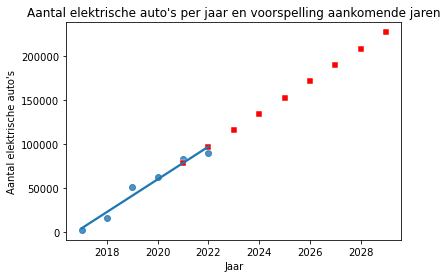

In [13]:
st.subheader("Voorspelling aantal elektrische auto's") 
st.text("Doormiddel van de variabelen in de datasets is er een voorspelling gedaan over het aantal elektrische auto's.")
st.text('Dit hebben wij kunnen doen door bepaalde gegevens te voorspellen en uit te zetten over de jaren later')
st.text("Uit de figuur hieronder blijkt dat het aantal elektrische auto's tot met 2030 zal toenemen'")
st.text('De blauwe bolletjes geven de echte waardes aan in de jaren die al gegeven zijn')
st.text('De blauwe lijn geeft het gemiddelde aan door de blauwe bolletjes')
st.text('Om te voorspellen wat er in de jaren na de blauwe bolletjes gebeurt,')
st.text('zijn er "predictions" gemaakt die zijn gebaseerd op de gegeven punten')
st.text('De rode bolletjes vormen de voorspelling in de toekomst')
st.text("Hieruit zal blijken dat de aanschaf van elektrische auto's toeneemt in de toekomst")

# Create sqrt_dist_to_mrt_m

aantal_per_jaar = df_elek.groupby('jaar_tenaamstelling')['Kenteken'].count().reset_index()

groter_2017jaar = aantal_per_jaar[(aantal_per_jaar['jaar_tenaamstelling'] >= 2017)]

groter_2017jaar['jaar_tenaamstelling'] = groter_2017jaar['jaar_tenaamstelling'].astype(np.int64)
groter_2017jaar.jaar_tenaamstelling.dtype

regressie = ols("Kenteken~ jaar_tenaamstelling", data=groter_2017jaar).fit()

explanatory_data = pd.DataFrame({"jaar_tenaamstelling":np.arange(2021,2030)})
prediction_data = explanatory_data.assign(Kenteken=regressie.predict(explanatory_data))

tips = sns.load_dataset("tips")

fig = plt.figure()

ax1 = sns.regplot(x="jaar_tenaamstelling",
            y="Kenteken",            
            ci=None,            
            data=groter_2017jaar,)
ax2 = sns.scatterplot(x="jaar_tenaamstelling",
                y="Kenteken",                
                data=prediction_data,                 
                color="red",                
                marker="s")
ax1.set(xlabel='Jaar', ylabel="Aantal elektrische auto's")
ax1.set(title="Aantal elektrische auto's per jaar en voorspelling aankomende jaren")

st.pyplot(fig)